# Bibliotecas

In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Dataframe dos resultados

In [2]:
path = "/home/lucas/experimentos/Transformer_Torch_V3_sigmoid/version_0/metrics.csv"

df = pd.read_csv(path)
df

,loss,epoch,step,val_loss
0,2951843.75,0,49,NaN
1,3159313.00,0,99,NaN
2,2783357.50,0,149,NaN
3,NaN,0,188,2951598.75
4,2458459.00,1,199,NaN
...,...,...,...,...
152,2495158.25,32,6049,NaN
153,2291702.25,32,6099,NaN
154,3083951.25,32,6149,NaN
155,2893222.50,32,6199,NaN


# 2. Obtendo a loss de treino e de validacao

## 2.1 Validacao

In [3]:
#df_val_loss = df[df['val_loss'].apply(lambda x: pd.notna(x))].copy()
df_val_loss = df[["epoch","val_loss"]].copy()
df_val_loss.rename({"val_loss":"loss"},inplace=True,axis=1)
df_val_loss["Split"] = "Validação"

df_val_loss = df_val_loss[df_val_loss.loss.apply(lambda x: pd.notna(x))]
df_val_loss

,epoch,loss,Split
3,0,2951598.75,Validação
8,1,2951598.75,Validação
13,2,2950159.00,Validação
18,3,2950159.00,Validação
22,4,2950159.00,Validação
27,5,2950159.00,Validação
32,6,2950159.00,Validação
37,7,2950159.00,Validação
42,8,2950159.00,Validação
46,9,2950159.00,Validação


## 2.2 Treino

In [4]:
#index_val = df_val_loss.index.tolist()

#index_val = [x - 1 for x in index_val]
#df_train_loss = df.loc[index_val].copy()
df_train_loss = df[["epoch","loss"]].copy()

df_train_loss["Split"] = "Treino"
df_train_loss

,epoch,loss,Split
0,0,2951843.75,Treino
1,0,3159313.00,Treino
2,0,2783357.50,Treino
3,0,NaN,Treino
4,1,2458459.00,Treino
...,...,...,...
152,32,2495158.25,Treino
153,32,2291702.25,Treino
154,32,3083951.25,Treino
155,32,2893222.50,Treino


# 3. Grafico comparativo de Loss

In [5]:
df_concat = pd.concat([df_train_loss,df_val_loss])

<Axes: xlabel='epoch', ylabel='loss'>

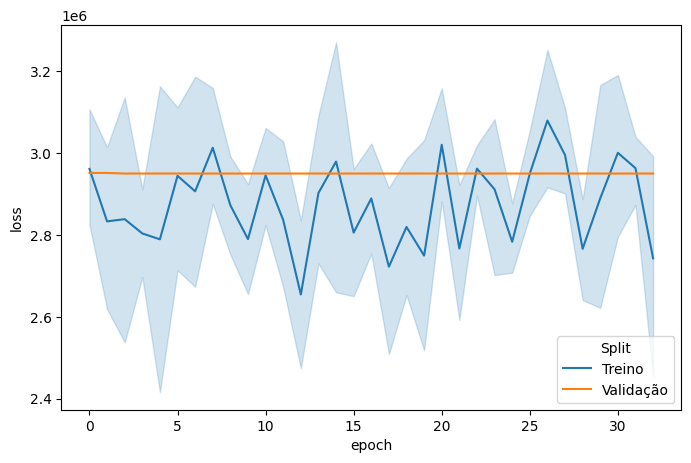

In [6]:
fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(data=df_concat,x="epoch",y="loss",hue="Split",ax=ax)

#sns.lineplot(data=df,x="epoch",y="loss",ax=ax)
#sns.lineplot(data=df,x="epoch",y="val_loss",ax=ax)

# 4. Load Model

In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

import sys
sys.path.append("/home/lucas/Image-Denoising/src")


import pandas as pd
from PIL import Image
from tqdm import tqdm

from models import VisionModelTransformerTorchV3 as VisionModel
from noises import add_noise
from dataset import CustomImageDataset

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from modules.train_module import TrainModule
from torchvision.transforms import v2

from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch import Trainer

/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
class AddNoise(torch.nn.Module):
    def forward(self, img, noise,**kwargs):
        noisy_image = add_noise(img, noise_type=noise,**kwargs)

        return Image.fromarray(noisy_image)

batch_size = 2
num_workers = 8
lr = 0.001

noise = AddNoise()
transform = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True)
])

path = "/home/lucas/Image-Denoising/dataframes/dataframe_v1.csv"
df = pd.read_csv(path)

val = df[df["split"] == 'val']
train = df[df["split"] == 'train']

val_dataset = CustomImageDataset(val,transform,noise)
train_dataset = CustomImageDataset(train,transform,noise)


custom_dataloader_val = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False)


custom_dataloader_train = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False)



model = VisionModel(img_size=(2,3,224,224), patch_size=14, token_len=512, embed_dim=512, num_heads=8, num_layers=6)

model = model.cpu()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

#model = TrainModule.load_from_checkpoint(
#    "/home/lucas/experimentos/Transformer_Torch_V3_sigmoid/version_0/checkpoint-epoch=02-val_loss=2950159.0000000000.ckpt",
#    map_location={"cuda:0":"cpu","cuda:1":"cpu","cuda":"cpu"},
#    model=model,
#    loss=loss_fn,
#    optim=optimizer
#)

/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# 5 Testando inferencias

In [3]:
i = 0
stop = 4
for ori_img, noi_img in custom_dataloader_val:
    if(i == stop):
        break
    i+=1

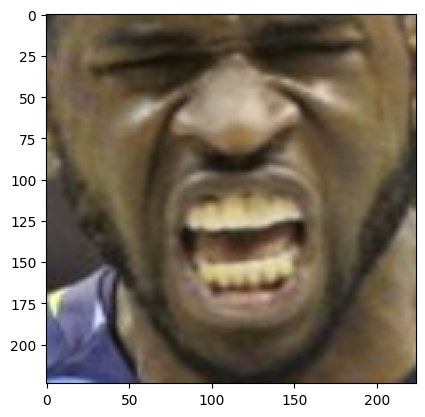

In [4]:
plt.imshow(ori_img[1].permute(1,2,0).detach().numpy())

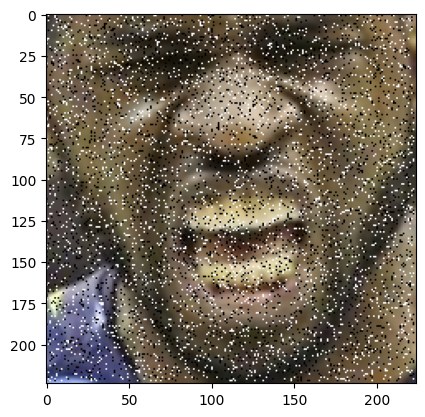

In [5]:
plt.imshow(noi_img[1].permute(1,2,0).detach().numpy())

In [7]:
denoised = model(noi_img)

In [11]:
torch.sigmoid(denoised)

tensor([[[0.0056, 0.9283, 0.5415,  ..., 0.9993, 0.9613, 0.9101],
         [0.0054, 0.9889, 0.3371,  ..., 0.9997, 0.9788, 0.9522],
         [0.0025, 0.8515, 0.6380,  ..., 0.9991, 0.9712, 0.9202],
         ...,
         [0.0023, 0.9904, 0.5422,  ..., 0.9847, 0.9988, 0.9482],
         [0.0021, 0.9842, 0.5611,  ..., 0.9974, 0.9867, 0.9848],
         [0.0202, 0.9681, 0.5816,  ..., 0.9923, 0.9260, 0.8292]],

        [[0.0117, 0.8707, 0.4455,  ..., 0.9993, 0.9934, 0.9204],
         [0.0334, 0.9470, 0.3476,  ..., 0.9984, 0.9851, 0.6578],
         [0.0070, 0.9845, 0.4933,  ..., 0.9968, 0.9942, 0.6675],
         ...,
         [0.0522, 0.8824, 0.7417,  ..., 0.9771, 0.9869, 0.7649],
         [0.0101, 0.9552, 0.8306,  ..., 0.9818, 0.9928, 0.8509],
         [0.0155, 0.8446, 0.6741,  ..., 0.9874, 0.9827, 0.7700]]],
       grad_fn=<SigmoidBackward0>)

In [9]:
model.sigmoid(denoised)

tensor([[[0.0056, 0.9283, 0.5415,  ..., 0.9993, 0.9613, 0.9101],
         [0.0054, 0.9889, 0.3371,  ..., 0.9997, 0.9788, 0.9522],
         [0.0025, 0.8515, 0.6380,  ..., 0.9991, 0.9712, 0.9202],
         ...,
         [0.0023, 0.9904, 0.5422,  ..., 0.9847, 0.9988, 0.9482],
         [0.0021, 0.9842, 0.5611,  ..., 0.9974, 0.9867, 0.9848],
         [0.0202, 0.9681, 0.5816,  ..., 0.9923, 0.9260, 0.8292]],

        [[0.0117, 0.8707, 0.4455,  ..., 0.9993, 0.9934, 0.9204],
         [0.0334, 0.9470, 0.3476,  ..., 0.9984, 0.9851, 0.6578],
         [0.0070, 0.9845, 0.4933,  ..., 0.9968, 0.9942, 0.6675],
         ...,
         [0.0522, 0.8824, 0.7417,  ..., 0.9771, 0.9869, 0.7649],
         [0.0101, 0.9552, 0.8306,  ..., 0.9818, 0.9928, 0.8509],
         [0.0155, 0.8446, 0.6741,  ..., 0.9874, 0.9827, 0.7700]]],
       grad_fn=<SigmoidBackward0>)

In [45]:
from models.tokenization import UnPatchTokenizationEinops

In [46]:
un_patch = UnPatchTokenizationEinops(14,224)

In [47]:
denoised = un_patch(denoised)

In [49]:
denoised

tensor([[[[1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 1., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 1.,  ..., 1., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 1., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 1.,  ..., 1., 0., 0.],
        

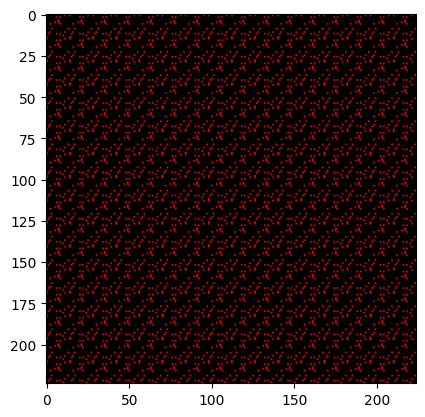

In [48]:
plt.imshow(denoised[1].permute(1,2,0).detach().numpy())

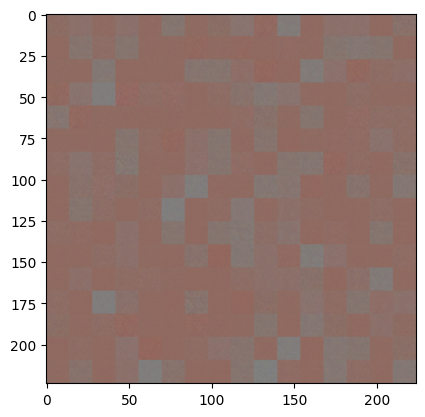

In [15]:
denoised_ = model.model.unpatch_tokenization(denoised[:,:-1,:])
plt.imshow(denoised_[0].permute(1,2,0).detach().numpy())

In [19]:
ori_img_ = model.model.patch_tokenization(ori_img)
denoised_ = model.model.patch_tokenization(denoised_)

In [20]:
denoised_.shape

torch.Size([2, 256, 512])

In [21]:
ori_img_.shape

torch.Size([2, 256, 512])

In [22]:
loss = nn.MSELoss(reduction='none')
loss = loss(denoised_,ori_img_)

In [27]:
torch.sum(loss,dim=-1).sum()

tensor(0.2339, grad_fn=<SumBackward0>)

In [41]:
torch.sum(loss,dim=-1).sum()/2

tensor(0.0484, grad_fn=<DivBackward0>)

In [33]:
denoised.shape

torch.Size([2, 257, 588])

In [55]:

#ori_img_ = model.model.linear(ori_img_)

In [56]:
ori_img_.shape

torch.Size([2, 256, 512])

In [58]:
denoised_.shape

torch.Size([2, 3, 224, 224])

In [59]:
denoised_ = model.model.patch_tokenization(denoised_)
denoised_.shape

torch.Size([2, 256, 512])

In [60]:
loss = nn.MSELoss(reduction='none')
loss = loss(denoised_,ori_img_)

In [61]:
loss.sum(dim=1).mean()

tensor(0.0006, grad_fn=<MeanBackward0>)

In [82]:
torch.mean(loss,dim=1).sum(dim=1).mean()

tensor(0.9580, grad_fn=<MeanBackward0>)

In [75]:
((ori_img_ - denoised_)**2).sum(dim=1).mean()

tensor(0.4790, grad_fn=<MeanBackward0>)

In [52]:
denoised[0].shape

torch.Size([3, 224, 224])

In [48]:
(ori_img[0] - noi_img[0]).sum(dim=1).mean()

tensor(3.4154)

In [50]:
loss = nn.MSELoss()

In [64]:
loss(denoised[:,:-1,:],ori_img_)

tensor(3.8718e-05, grad_fn=<MseLossBackward0>)

In [17]:
denoised_.shape

torch.Size([2, 3, 224, 224])

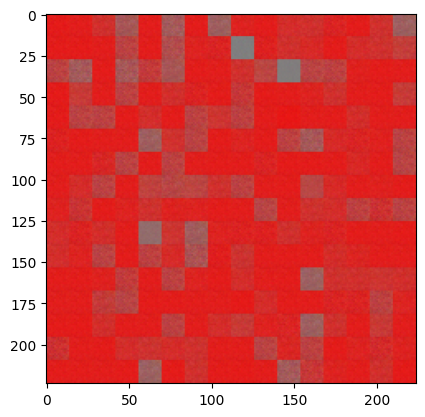

In [36]:
plt.imshow(denoised_[0].permute(1,2,0).detach().numpy())